# Strategic Patient Risk Stratification & Readmission Modeling
## Vitality Health Network (VHN)

**Module:** ITS 2122 – Python for Data Science & AI  
**Dataset:** Diabetes 130-US Hospitals (1999–2008)


## Phase 1: Data Ingestion & Clinical Sanitation

Clinical datasets are inherently noisy.  
This phase ensures data reliability by:
- Standardizing missing values
- Removing deceased patients
- Encoding clinical features
- Preparing a clean analytical dataset


In [1]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("../data/processed/cleaned_data.csv")
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286 entries, 0 to 285
Data columns (total 50 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   encounter_id              286 non-null    int64 
 1   patient_nbr               286 non-null    int64 
 2   race                      286 non-null    object
 3   gender                    286 non-null    object
 4   age                       286 non-null    object
 5   admission_type_id         286 non-null    int64 
 6   discharge_disposition_id  286 non-null    int64 
 7   admission_source_id       286 non-null    int64 
 8   time_in_hospital          286 non-null    int64 
 9   num_lab_procedures        286 non-null    int64 
 10  num_procedures            286 non-null    int64 
 11  num_medications           286 non-null    int64 
 12  number_outpatient         286 non-null    int64 
 13  number_emergency          286 non-null    int64 
 14  number_inpatient          

## Phase 2: ICD-9 Diagnosis Enrichment (Web Scraping)

ICD-9 diagnosis codes are cryptic for non-clinical stakeholders.
We enrich the dataset by scraping human-readable descriptions
for the **Top 20 most frequent primary diagnoses**.


## Phase 3: Exploratory Data Analysis (EDA)

This phase uncovers demographic, clinical, and operational
drivers of readmission risk.


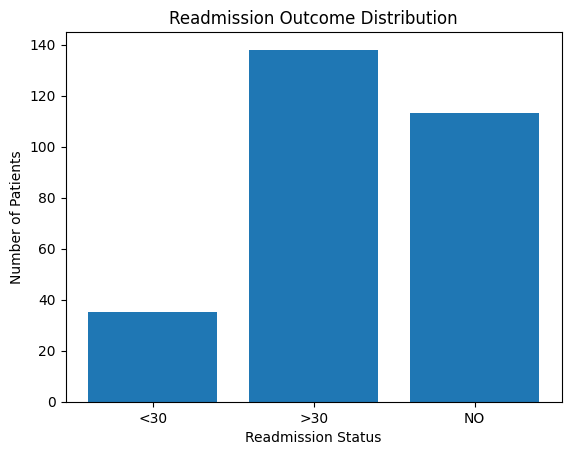

In [2]:
import matplotlib.pyplot as plt

counts = df["readmitted"].value_counts().sort_index()

plt.figure()
plt.bar(counts.index, counts.values)
plt.title("Readmission Outcome Distribution")
plt.xlabel("Readmission Status")
plt.ylabel("Number of Patients")
plt.show()


### Medication Efficacy & Readmission Risk

We compare insulin users versus oral medication users to
assess whether insulin therapy signals higher severity.


## Phase 4: Vitality Complexity Index (VCI)

The VCI is inspired by the LACE Index and provides a simple,
actionable risk score for nursing staff.


In [3]:
def calculate_vci(row):
    # L
    if row["time_in_hospital"] < 1:
        L = 0
    elif row["time_in_hospital"] <= 4:
        L = 1
    elif row["time_in_hospital"] <= 13:
        L = 4
    else:
        L = 7

    # A
    A = 3 if row["admission_type"] in ["Emergency", "Trauma Center"] else 0

    # C
    if row["number_diagnoses"] < 4:
        C = 0
    elif row["number_diagnoses"] <= 7:
        C = 3
    else:
        C = 5

    # E
    if row["number_emergency"] == 0:
        E = 0
    elif row["number_emergency"] <= 4:
        E = 3
    else:
        E = 5

    return L + A + C + E

df["VCI_Score"] = df.apply(calculate_vci, axis=1)


### VCI Risk Stratification & Validation

We validate the VCI by comparing <30-day readmission rates
across Low, Medium, and High risk groups.


C:\Users\Charuka\AppData\Local\Temp\ipykernel_5048\2741911358.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  readmission_rates = df.groupby("VCI_Risk")["readmitted_binary"].mean()


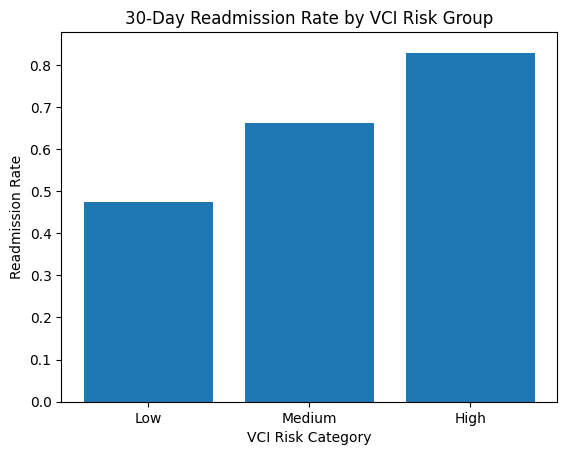

In [4]:
# Risk stratification (same logic)
df["VCI_Risk"] = pd.cut(
    df["VCI_Score"],
    bins=[-1, 6, 10, 100],
    labels=["Low", "Medium", "High"]
)

# Calculate readmission rates
readmission_rates = df.groupby("VCI_Risk")["readmitted_binary"].mean()

# Plot
plt.figure()
plt.bar(
    readmission_rates.index.astype(str),
    readmission_rates.values
)
plt.title("30-Day Readmission Rate by VCI Risk Group")
plt.xlabel("VCI Risk Category")
plt.ylabel("Readmission Rate")
plt.ylim(0, readmission_rates.max() + 0.05)
plt.show()
